# Redes totalmente convolucionais

Este notebook aborda os seguintes aspectos relacionados às redes totalmente convolucionais:

- como transformar uma camada densa em convolucional, aproveitando seus pesos;
- como criar, a partir de uma rede pré-treinada para classificar imagens, uma rede totalmente convolucional;
- demonstrar que uma rede totalmente convolucional, quando aplicada em imagens maiores que aquelas usadas em seu treinamento, implementa uma varredura implícita com ganhos de eficiência.
- apresentar um método para aumentar a resolução (*shift-and-stitch*)

## Motivação

### Rede 2 camadas convolucionais e 2 camadas densas

<img src='../figures/Rede_LeNet_like.png', width=800pt></img>

### Rede equivalente com 4 camadas convolucionais 

<img src='../figures/Rede_LeNet_like_fully_convolutional.png', width=800pt></img>

## Importando os módulos

In [1]:
%matplotlib inline

import numpy as np
import sys,os
import matplotlib.pyplot as plt
from IPython import display
from collections import OrderedDict

# from torch
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import lr_scheduler

# from torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# from course libs
sys.path.append('./lib')

In [2]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)

Usando GPU: False


## Carregando MNIST dataset

In [3]:
dataset_dir = '/data/datasets/MNIST/'

# Transformara os dados em tensores no intervalo [0.0, 1.0] (Os dados serão normalizados)
data_transform = transforms.ToTensor()
# data_transform = None

# carrega o conjunto de treinamento e de teste
datasets = dict(train=MNIST(dataset_dir, train=True, transform=data_transform, download=False),
                val=MNIST(dataset_dir, train=False, transform=data_transform, download=False))

dataloaders = dict(train=torch.utils.data.DataLoader(dataset=datasets['train'], batch_size=len(datasets['train']), shuffle=True),
                   val=torch.utils.data.DataLoader(dataset=datasets['val'], batch_size=len(datasets['val']), shuffle=False))

print('Amostras para treinamento:', len(datasets['train']))
print('Amostras para validação:', len(datasets['val']))
print(type(datasets['train'].train_data))
print(datasets['train'].train_data.size())
print(datasets['train'].train_data.min(), datasets['train'].train_data.max())

Amostras para treinamento: 60000
Amostras para validação: 10000
<class 'torch.ByteTensor'>
torch.Size([60000, 28, 28])
0 255


## Pequena amostra apenas para testar o código

In [4]:
if True:
    n_samples_train = 1000
    n_samples_test  = 500

    datasets['train'].train_data = datasets['train'].train_data[:n_samples_train]
    datasets['train'].train_labels = datasets['train'].train_labels[:n_samples_train]
    datasets['val'].test_data = datasets['val'].test_data[:n_samples_test]
    datasets['val'].test_labels = datasets['val'].test_labels[:n_samples_test]
    
    print('Amostras para treinamento:', len(datasets['train']))
    print('Amostras para validação:', len(datasets['val']))

Amostras para treinamento: 1000
Amostras para validação: 500


## Definição do modelo com camadas densas (igual ao notebook anterior)

In [5]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        # Camadas convolucionais
        self.conv_layer = nn.Sequential(OrderedDict([
            # lembrar de usar zero padding para manter o tamanho da imagem
            ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, padding=2)),   
            ('relu1', nn.ReLU()),
            ('max_pool1', nn.MaxPool2d(2)),

            ('conv2', nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, padding=2)),
            ('relu2', nn.ReLU()),
            ('max_pool2', nn.MaxPool2d(2)),
            
            ('drop', nn.Dropout(p=0.5))
        ]))
        
        # Camadas densas
        self.dense_layer = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(in_features=2450, out_features=50)),
            ('relu1', nn.ReLU()),
            ('dense2', nn.Linear(in_features=50, out_features=10)),
        ]))
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(-1, 2450)  # Transforma a matriz em vetor
        x = self.dense_layer(x)
        
        return x

## Carregando nosso modelo pré-treinado anteriormente

Iremos converter a rede já treinada no exemplo anterior. Caso a próxima célula deste notebook
der erro, é muito provável que o modelo da rede não foi salvo. Deve-se portanto executar o notebook:

- [keras-lenet-mnist.ipynb](keras-lenet-mnist.ipynb)

In [6]:
model_name = '/data/models/lenet-mnist.model'
saved_weights = torch.load(model_name)

model_dense = MyModel()
model_dense.load_state_dict(saved_weights)

In [7]:
# model_dense = model_dense.cpu()
# criterion = nn.CrossEntropyLoss()
# preds_dense, _ = test_network(model_dense, datasets['val'], criterion, use_gpu=False)

x, y = next(iter(dataloaders['val']))
preds_dense = torch.max(model_dense(torch.autograd.Variable(x, volatile=True)), dim=1)[1].data

## Modelo totalmente convolucional equivalente

O modelo seguinte é todo ele convolucional.

A primeira camada densa do modelo tem como entrada um tensor de dimensão 2450, resultante do redimensionamento (via *Flatten*) da saída do *Dropout*, 50x7x7. Esta camada gera uma saída com dimensão 50. Seus pesos têm portanto dimensão 2450x50.

Uma camada convolucional que substitua estas camadas *Flatten* e *Dense* terá como entrada um tensor 50x7x7. Para gerar uma saída 50x1x1, a convolução deve criar 50 mapas com um kernel 7x7 e com borda do tipo 'valid'.

Para substituir a última camada densa, usamos uma convolução com 10 mapas e kernel 1x1.


In [8]:
class MyModelFullyConv(nn.Module):
    def __init__(self):
        super(MyModelFullyConv, self).__init__()
        
        # Camadas convolucionais
        self.conv_layer = nn.Sequential(OrderedDict([
            # lembrar de usar zero padding para manter o tamanho da imagem
            ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, padding=2)),   
            ('relu1', nn.ReLU()),
            ('max_pool1', nn.MaxPool2d(2)),

            ('conv2', nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, padding=2)),
            ('relu2', nn.ReLU()),
            ('max_pool2', nn.MaxPool2d(2)),
            
            ('conv3', nn.Conv2d(in_channels=50, out_channels=50, kernel_size=7)),
            ('relu3', nn.ReLU()),
            
            ('conv4', nn.Conv2d(in_channels=50, out_channels=10, kernel_size=1)),
        ]))
        
    def forward(self, x):
        x = self.conv_layer(x)        
        x = x.view(-1, 10)
        return x

### Observando a saida de cada camada

In [9]:
model_conv = MyModelFullyConv()

x = Variable(torch.zeros(1, 1, 28, 28))

print('{:10}: {}'.format('input', str(x.size())))

for name, layer in model_conv.conv_layer.named_children():
    x = layer(x)
    print('{:10}: {}'.format(name, str(x.size())))

input     : torch.Size([1, 1, 28, 28])
conv1     : torch.Size([1, 20, 28, 28])
relu1     : torch.Size([1, 20, 28, 28])
max_pool1 : torch.Size([1, 20, 14, 14])
conv2     : torch.Size([1, 50, 14, 14])
relu2     : torch.Size([1, 50, 14, 14])
max_pool2 : torch.Size([1, 50, 7, 7])
conv3     : torch.Size([1, 50, 1, 1])
relu3     : torch.Size([1, 50, 1, 1])
conv4     : torch.Size([1, 10, 1, 1])


### comparando o tamanho dos pesos das duas redes

In [10]:
def print_weights_size(weight_dict):
    for name, weight in weight_dict.items():
        print('{:25} -> {}'.format(name, weight.size()))

In [11]:
print('--Pesos no modelo dense--')
print_weights_size(model_dense.state_dict())
print('\n--Pesos no modelo fully convolutional--')
print_weights_size(model_conv.state_dict())

--Pesos no modelo dense--
conv_layer.conv1.weight   -> torch.Size([20, 1, 5, 5])
conv_layer.conv1.bias     -> torch.Size([20])
conv_layer.conv2.weight   -> torch.Size([50, 20, 5, 5])
conv_layer.conv2.bias     -> torch.Size([50])
dense_layer.dense1.weight -> torch.Size([50, 2450])
dense_layer.dense1.bias   -> torch.Size([50])
dense_layer.dense2.weight -> torch.Size([10, 50])
dense_layer.dense2.bias   -> torch.Size([10])

--Pesos no modelo fully convolutional--
conv_layer.conv1.weight   -> torch.Size([20, 1, 5, 5])
conv_layer.conv1.bias     -> torch.Size([20])
conv_layer.conv2.weight   -> torch.Size([50, 20, 5, 5])
conv_layer.conv2.bias     -> torch.Size([50])
conv_layer.conv3.weight   -> torch.Size([50, 50, 7, 7])
conv_layer.conv3.bias     -> torch.Size([50])
conv_layer.conv4.weight   -> torch.Size([10, 50, 1, 1])
conv_layer.conv4.bias     -> torch.Size([10])


## Ajustando os pesos do modelo todo convolucional

In [12]:
w_dense = model_dense.state_dict()
w_conv = model_conv.state_dict()

# Só precisamos ajustar as dimensões dos pesos das camadas:
# - dense1.weight para o tamanho de conv3.weight
# - dense2.weight para o tamanho de conv4.weight
# As outras camadas serão somente copiadas

# weigths
w_conv['conv_layer.conv1.weight'] = w_dense['conv_layer.conv1.weight']
w_conv['conv_layer.conv2.weight'] = w_dense['conv_layer.conv2.weight']
w_conv['conv_layer.conv3.weight'] = w_dense['dense_layer.dense1.weight'].view(50, 50, 7, 7)
w_conv['conv_layer.conv4.weight'] = w_dense['dense_layer.dense2.weight'].view(10, 50, 1, 1)

# bias
w_conv['conv_layer.conv1.bias'] = w_dense['conv_layer.conv1.bias']
w_conv['conv_layer.conv2.bias'] = w_dense['conv_layer.conv2.bias']
w_conv['conv_layer.conv3.bias'] = w_dense['dense_layer.dense1.bias']
w_conv['conv_layer.conv4.bias'] = w_dense['dense_layer.dense2.bias']

model_conv.load_state_dict(w_conv)

## Verificando se o desempenho é o mesmo

Uma vez que colocamos na rede B os pesos da rede A, precisamos verificar se o desempenho da rede B (totalmente convolucional)
possui o mesmo desempenho da rede A.
Fazermos isso medindo a acurácia das duas redes no conjunto de testes.

In [13]:
# model_conv.cpu()
# criterion = nn.CrossEntropyLoss()
# preds_conv, _ = test_network(model_conv, datasets['val'], criterion, use_gpu=False)

x, y = next(iter(dataloaders['val']))
preds_conv = torch.max(model_conv(torch.autograd.Variable(x, volatile=True)), dim=1)[1].data

In [14]:
# Mostra os 10 primeiros elementos preditos
labels = datasets['val'].test_labels

print('{:6}: {}'.format('labels', labels[:10]))
print('{:6}: {}'.format('dense', preds_dense[:10]))
print('{:6}: {}'.format('conv', preds_conv[:10]))

labels: 
 7
 2
 1
 0
 4
 1
 4
 9
 5
 9
[torch.LongTensor of size 10]

dense : 
 7
 2
 1
 0
 4
 1
 4
 9
 5
 9
[torch.LongTensor of size 10]

conv  : 
 7
 2
 1
 0
 4
 1
 4
 9
 5
 9
[torch.LongTensor of size 10]



In [15]:
print('Acurácia rede totalmente convolucional: {:.5}%'.format(100.0 *(preds_conv == labels).sum() / labels.shape[0]))
print('Acurácia rede clássica:                 {:.5}%'.format(100.0 * (preds_dense == labels).sum() / labels.shape[0]))

Acurácia rede totalmente convolucional: 98.8%
Acurácia rede clássica:                 98.2%


# Aplicando o classificador numa imagem maior que 28x28

In [16]:
labels = datasets['val'].test_labels
x_test = datasets['val'].test_data

In [17]:
# Função para criar uma imagem de teste, maior que 28x28 colocando várias amostras
def make_image(X_test, y_test, M=200, H=28, W=28):
    char_index = np.random.choice(X_test.shape[0], 10, replace=False)
    char_img = [img.reshape(H,W) for img in (X_test)[char_index]]
    char_lab = [y for y in y_test[char_index]]

    image = np.zeros((M, M), np.uint8)
    coords = [(20, 20), (50, 150), (100, 100), (151, 151), (120,30)] # posição das imagens na imagem maior
    xlabel = []
    for k, (i, j) in enumerate(coords):
        image[i:i+H, j:j+W] = char_img[k]
        xlabel.append(char_lab[k])
    return image, coords, xlabel

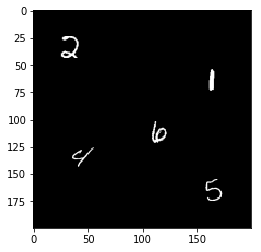

In [18]:
M = 200
image, coords, xlabel = make_image(x_test.numpy(), labels.numpy(), M) # Construindo uma imagem para testes M x M com 4 dígitos
plt.imshow(image, cmap='gray');

## Aplicando classificador na imagem 200 x 200

In [19]:
print(image.shape)

(200, 200)


In [29]:
# transforma imagem de input em Tensor e em seguida a coloca em uma variável
in_image = image.reshape(1, 1, M, M)
in_image = torch.from_numpy(in_image).type(torch.FloatTensor)
in_image = Variable(in_image)
print('{:30}{}'.format('tamanho na entrada:', in_image.size()))

# passa a imagem pela rede e faz o padding de 3 para a imagem ficar com tamanho (50, 50)
output = model_conv.conv_layer(in_image)
print('{:30}{}'.format('tamanho na saída:', output.size()))
output = nn.functional.pad(output, (3,3,3,3))
print('{:30}{}'.format('tamanho após o padding:', output.size()))

# pega o maior valor entre as 10 classes
max_pred, max_class = torch.max(output, 1)
hot_map = max_pred.data.view(50, 50)
print('{:30}{}'.format('tamanho do hot map:', hot_map.size()))

tamanho na entrada:           torch.Size([1, 1, 200, 200])
tamanho na saída:             torch.Size([1, 10, 44, 44])
tamanho após o padding:       torch.Size([1, 10, 50, 50])
tamanho do hot map:           torch.Size([50, 50])


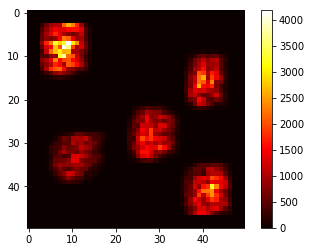

In [30]:
plt.imshow(hot_map.numpy(), plt.cm.hot)
plt.colorbar()
plt.show()

### Imagem de probabilidade máxima de cada pixel referente a uma janela 28x28 (mapa de calor)

4185.60693359375


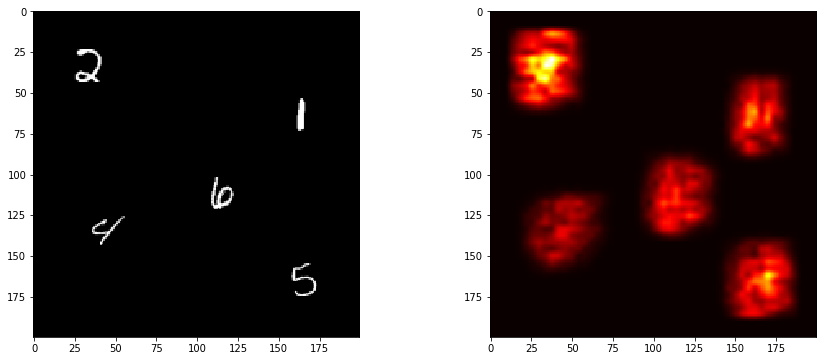

In [31]:
fig = plt.figure(figsize=(15,6)) 

fig.add_subplot(1,2,1)
plt.imshow(image, cmap='gray')

print(hot_map.max())
#hot_map = hot_map * hot_map>3500

import scipy.misc
hot_map = scipy.misc.imresize(hot_map.numpy(), (200, 200))

fig.add_subplot(1,2,2)
plt.imshow(hot_map, cmap=plt.cm.hot)
plt.show()

**Atenção:** Observe que as duas imagens acima possuem resolução (*shape*) diferentes. A resolução da imagem de entrada, mostrada à esquerda, é de (200,200) e a resolução da imagem de saída (à direita) é de (50,50).

## Aumentando a resolução para obter a mesma resolução da imagem de entrada

Observe que a cada janela de 4x4 pixels da imagem de entrada, existe um resultado na imagem de saída.

O objetivo agora é conseguir fazer com que a imagem resultante tenha o mesmo shape da imagem de entrada.

## Janela deslizante

Agora que temos uma rede toda convolucional, vejamos o que acontece se a imagem de entrada é maior que as imagens utilizadas para treinamento (28x28).

A figura abaixo, ilustra o processo mostrando as dimensões dos *features* através de uma linha da imagem de entrada com dimensões 36x36. Acompanhemos cada passo:

- imagem de entrada (representada na figura em uma dimensão apenas): 1x36x36;
- convolução 20 filtros 5x5, borda *'same'*: 20x36x36
- maxpool 2x2, stride 2x2: 20x18x18
- convolução 50 filtros 5x5, borda *'same'*: 50x18x18
- maxpool 2x2, stride 2x2: 50x9x9
- convolução 50 filtros 7x7, borda *'valid'*: 50x3x3
- convolução 10 filtros 1x1: 10x3x3

<table align='left'>
<!-- <tr><td> <img src="../figures/fully_conv_4.png" alt="Drawing" style="width: 200px;"/> </td> <td/></tr> -->
<tr><td colspan=2> <img src="../figures/fully_conv_3.png" alt="Drawing" style="width: 600px;"/> </td></tr>
</table>

### Demonstrando a técnica de *shift* e *stitch*

In [35]:
M = 36
H = 28
W = 28

import time
# Para demonstrar a técnica shift e stitch
def show_scan(M, H=28, W=28):
    from IPython import display
    def printt(arr):
        for line in output.tolist():
            print(' '.join([' abcdefghijklmnop'[x] for x in line]))

    M = 36
    image = np.zeros((1, 1, M, M))

    lab = 1
    output = np.zeros((M-H+1, M-W+1), np.uint8)
    for i in range(4):
        for j in range(4):
            oo = output[i::4, j::4]
            output[i::4, j::4] = lab * np.ones_like(oo)
            print('origin: ({}, {}), shape: {}, label: {}'.format(i, j, oo.shape, ' abcdefghijklmnop'[lab]))
            print()
            printt(output)
            lab += 1
            time.sleep(2)
            display.clear_output(wait=True)

In [33]:
show_scan(M) # Demonstração da varredura e preenchimento (shift, stitch)

origin: (3, 3), shape: (2, 2), label: p

a b c d a b c d a
e f g h e f g h e
i j k l i j k l i
m n o p m n o p m
a b c d a b c d a
e f g h e f g h e
i j k l i j k l i
m n o p m n o p m
a b c d a b c d a


## Rodando o classificador 16 vezes, preenchendo na forma shift-stitch

NameError: name 'model_B' is not defined

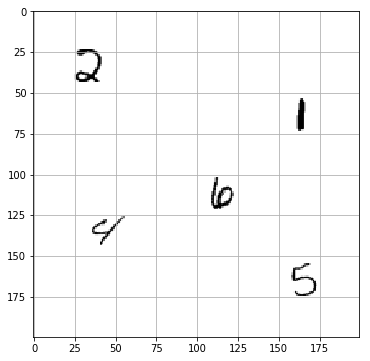

In [36]:
fig = plt.figure(figsize=(15,6)) 

fig.add_subplot(1,2,1)
plt.imshow(255 - image, cmap=plt.cm.gray)
plt.grid(True)

# Aplicando a técnica shift e stitch na imagem
# A rede convolucional é aplicada na imagem, 16 vezes para
# preencher os dados
output = np.zeros((10, M-H+1, M-W+1), np.float32)
for i in range(4):
    for j in range(4):
        output[:, i::4, j::4] = oo = model_B.predict(in_image[:, :, i:, j:])[0] # Execução da rede
        print(i, j, oo.shape)

output = softmax(output, axis=0)
pmax = output.max(0)
y_hat = output.argmax(0)
pmax = np.where(pmax < 0.3, 0, pmax)
print(pmax.min(), pmax.max())
print(pmax.shape)

pmax_img = np.zeros((M,M), pmax.dtype)
pmax_img[(H+1)//2-1:-H//2, (W+1)//2-1:-W//2] = pmax

y_hat_img = np.zeros((M,M), y_hat.dtype)
y_hat_img[(H+1)//2-1:-H//2, (W+1)//2-1:-W//2] = y_hat

fig.add_subplot(1,2,2)
plt.imshow(255 * (1.0 - pmax_img), cmap=plot.cm.hot)
# plot.imsave('heatmap.png', 255 * pmax)
plt.grid(True)

## Mostrando as probabilidades dos picos do mapa de calor

In [37]:
for k, (i, j) in zip(xlabel, coords):
    for m in (-1, 0, 1):
        for n in (-1, 0, 1):
            print('p = {:.5f}, char: \'{}\' [correct: \'{}\']'.format(pmax_img[i+m+13, j+n+13], 
                                                                      y_hat_img[i+m+13, j+n+13], k), end=' ')
            if m == n == 0:
                print('**')
            else:
                print()
    print()

NameError: name 'pmax_img' is not defined

## Observações

- A rede base utilizada não foi treinada para a não-ocorrência de um dos dez caracteres, nem de recortes parciais dos caracteres originais.
- Um exercício interessante seria treinar o modelo com os caracteres sobrepostos a imagens de fundo, além de recortes do fundo sem caracter (11 classes).


## Aprendizados com este notebook
